# Theory of melt ponds in the Arctic sea ice

<img src="https://drive.google.com/uc?id=1T7_FTKamrhD7NW-2R5yvjw4Vd9z8ljOe" width="700"/>  
<sup>Figure 1: Melt ponds cover all floes in the Arctic summer (picture taken by Victor Lion during Polarstern cruise PS131)<sup>

## Formation process 

Melting of cryosphere compartments creates melt ponds on the ice floes. These ponds are fed on the one hand by melt water from snow on the ice, which begins to melt with the onset of increased temperatures around June each year. On the other hand, the ice on the floes counts as a source of the water, which flows to the melt ponds with a time lag. Melt ponds occur during summer months in the Arctic on almost all ice floes and can form and change in a short time interval [König & Oppelt 2020]. 

15 July 2022             |  22 July 2022 |  31 July 2022
:-------------------------:|:-------------------------:|:-------------------------:
![](https://drive.google.com/uc?id=1m4fVUF2jOjQ89nEEI5IAuERliBQdE7TK)  |  ![](https://drive.google.com/uc?id=1lMeizQMWOOFN7tZkxhQ4mRdiBE96cFo8) |  ![](https://drive.google.com/uc?id=18IYtOFA_bFEzxrySHWRE8a6AC4hsNCxq)

<sup>Table 1: Development of pond Nemo within approx. two weeks (pictures taken by Victor Lion during Polarstern cruise PS131)<sup>

##  Importance of melt ponds and their observation

The development of melt water on ice floes causes an intensification of the further melting process. This self-reinforcing process is understood as ice-albedo-feedback. The albedo (ratio between the reflected and incident solar radiation from the surface) of water surfaces is significantly lower than that of ice surfaces. Thus, if higher temperature in the Arctic lead to the formation of melt ponds on the ice floes, this leads to an increased absorption capacity of the earth's surface due to lower albedo. The increased absorption of the water in turn leads to an increase in temperature and the process is repeated and intensified [Thackeray & Hall 2019]. 

## Visual appearance of melt ponds

Melt ponds occur with extreme variability in size, depth, and color. Even within a melt pond, different water depths and mostly different color tones are present, so each pond has a distinct characteristic. Melt ponds can range in length from several to hundreds of meters and have depth ranging from several centimeters to meters. They have a wide spectrum of colors (from dark grey to light blue), and the color is not an indicator of the water depth. The color can rather be explained by the optical thickness of the underlying ice. The optical thickness depends, among other things, on whether the ice is thin or perennial, thick ice [Zege et al. 2015]. 

<img src="https://drive.google.com/uc?id=1NIId-8gIBblj2SWflQi1hnaQnDjuf93p" width="700"/>  

<sup>Figure 2: Complex visual appearance of melt ponds (picture taken by Victor Lion during Polarstern cruise PS131)<sup>

# Data and preprocessing

Training data was retreived from a high resoulution (0.5 m) satellite classification data set during preprocessing. The data was used to train Sentinel-2 data (resolution: 10 m) originating from ESA's Copernicus programme.

<img src="https://drive.google.com/uc?id=106eJEsed83Jqtmi_mwuDg7BS8kIAHwqg" width="700"/>  

<sup>Figure 3: Reference data (left) and Sentinel-2 image (right).<sup>


In [1]:
%%capture
# install and import all libraries
!pip install rioxarray
!pip install rasterio

import numpy as np 
import tensorflow as tf 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import rioxarray as rxr
import xarray
import rasterio

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import data
data = pd.read_csv(r"/content/drive/MyDrive/Machine_Learning_TF/data/20200707_8perOL_v2.csv")

# delete features which were tried out but did not improve results
del_cols = ["entrophy_rad4", "entrophy_rad5" ,"entrophy_rad1","entrophy_rad2","entrophy_rad3", "TRI_b2", "TRI_b8"] 
for d in del_cols:
    del data[d]

# show me header of data
data.head()

FileNotFoundError: ignored

In [ ]:
print("data have " + str(len(data)) + " elements if unproccessed.")

# make an outlier detection 
def outlier_detection(df, col_name):
    Q1,Q3 = np.percentile(df[col_name] , [40,60])
    
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR
    
    df = df[df[col_name] > ll]
    df = df[df[col_name] < ul]
    return df
    

def transfrom_df(lower, upper, df):
    df = df[df.mpf >= lower]
    df = df[df.mpf < upper]
    
    df = outlier_detection(df, "b8")
    df = outlier_detection(df, "b2")
    df = outlier_detection(df, "b3")
    df = outlier_detection(df, "b4")
    
    # balance all classes so they are equally distributed
    smallest_class_size = 777
    if len(df.index) > smallest_class_size:
        df = df.sample(frac=1)
        df = df.head(smallest_class_size)
        
    df = df.sample(frac=1)   
    return df


# divide data into classes (10 % ranges) and select best data via outlier detection
df_class_0 = transfrom_df(-0.001, 0.1, data)
df_class_1 = transfrom_df(0.1, 0.2, data)
df_class_2 = transfrom_df(0.2, 0.3, data)
df_class_3 = transfrom_df(0.3, 0.4, data)
df_class_4 = transfrom_df(0.4, 0.5, data)
df_class_5 = transfrom_df(0.5, 0.6, data)
df_class_6 = transfrom_df(0.6, 0.7, data)
df_class_7 = transfrom_df(0.7, 0.8, data)
df_class_8 = transfrom_df(0.8, 0.9, data)
df_class_9 = transfrom_df(0.9, 1.01, data)

# create data frame of all classes and shuffle it before train test split
df_list = [df_class_0,df_class_1,df_class_2,df_class_3,df_class_4,
           df_class_5,df_class_6,df_class_7,df_class_8,df_class_9]

data = pd.concat(df_list, ignore_index=True) 
data = data.sample(frac=1)
      
print("data have " + str(len(data)) + " elements after cropping the classes.")

data have 48648 elements if unproccessed.
data have 7705 elements after cropping the classes.


# Creation of a Neural Net

In [ ]:
# divide dataframe in feature and label values 
X = data.drop(['mpf'], axis = 1)
y = data['mpf']

# split data into training and test data after shuffleling (random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 20)

# scale data before training the neural network
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# print number of training and test values 
print(len(X_train), 'training samples')
print(len(X_test), 'testing samples')


print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

6934 training samples
771 testing samples
Training Features Shape: (6934, 4)
Training Labels Shape: (6934,)
Testing Features Shape: (771, 4)
Testing Labels Shape: (771,)


In [ ]:
# define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128*2, activation = 'leaky_relu'),
    tf.keras.layers.Dense(64*2, activation = 'leaky_relu'), 
    tf.keras.layers.Dense(32*2, activation = 'leaky_relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(32*2, activation = 'relu'), 
    tf.keras.layers.Dense(16*2, activation = 'relu'), 
    tf.keras.layers.Dense(1)
])

# compile model
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])

# fit model
history = model.fit(X_train, y_train, epochs = 70, validation_split = 0.1)

Epoch 1/70
195/195 [==============================] - 3s 8ms/step - loss: 0.1026 - mean_absolute_error: 0.1026 - val_loss: 0.2233 - val_mean_absolute_error: 0.2233
Epoch 2/70
195/195 [==============================] - 1s 4ms/step - loss: 0.0787 - mean_absolute_error: 0.0787 - val_loss: 0.0994 - val_mean_absolute_error: 0.0994
Epoch 3/70
195/195 [==============================] - 1s 3ms/step - loss: 0.0661 - mean_absolute_error: 0.0661 - val_loss: 0.0676 - val_mean_absolute_error: 0.0676
Epoch 4/70
195/195 [==============================] - 1s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0650 - val_mean_absolute_error: 0.0650
Epoch 5/70
195/195 [==============================] - 1s 3ms/step - loss: 0.0658 - mean_absolute_error: 0.0658 - val_loss: 0.0580 - val_mean_absolute_error: 0.0580
Epoch 6/70
195/195 [==============================] - 1s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0715 - val_mean_absolute_error: 0.0715
Epoch 7/70
195/1

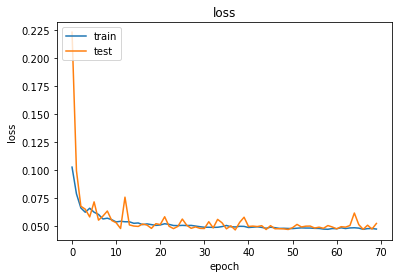

In [ ]:
# plot training and validation loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Performance evaluation

25/25 [==============================] - 0s 2ms/step


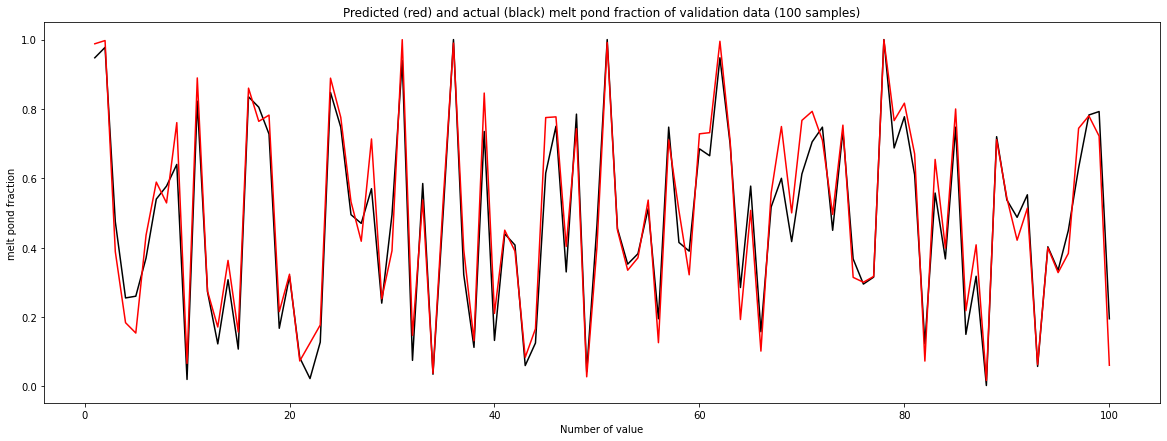

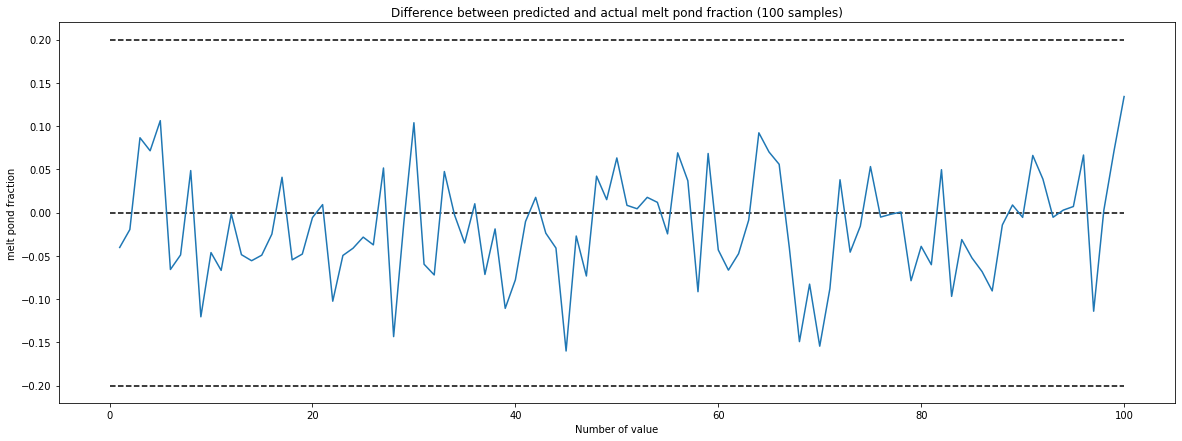

In [ ]:
# prediction of test dataset
y_pred = model.predict(X_test)

# create some plots to evaluate performance of the model

x_list = []
n = 1 
for i in range(100): 
    x_list.append(n)
    n = n + 1

df_plot = pd.DataFrame()
df_plot['y_test'] = y_test[:100]
df_plot['y_pred'] = y_pred[:100]
df_plot['x_list'] = x_list

plt.figure(figsize = (20, 7))
plt.plot(df_plot['x_list'], df_plot['y_test'], color = 'black')
plt.plot(df_plot['x_list'], df_plot['y_pred'], color = 'red')
plt.title('Predicted (red) and actual (black) melt pond fraction of validation data (100 samples)')
plt.xlabel('Number of value')
plt.ylabel('melt pond fraction')
plt.show()

plt.figure(figsize = (20, 7))
plt.plot(df_plot['x_list'], df_plot['y_test'] - df_plot['y_pred'])
plt.title('Difference between predicted and actual melt pond fraction (100 samples)')
plt.xlabel('Number of value')
plt.ylabel('melt pond fraction')
plt.hlines([0.2, 0, -0.2], xmin = 0, xmax = 100, linestyles = 'dashed')
plt.show()

As a rule of thumb, the mean absolute error value should be less than 10 % of the mean of the values to be predicted.

In [ ]:
# calculate and print MAE, MSE and RMSE of model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# define variable for evaluate result
mae_predicted = metrics.mean_absolute_error(y_test, y_pred)
mean_mpf = data['mpf'].mean()

# print MAE and Mean
print('Predicted MAE: ' + str(round(mae_predicted, 3)))
print('Mean of MPF: ' + str(round(mean_mpf, 3)))

# print if the neural network is generally working fine (regarding the rule of thumb from above)
if mae_predicted < mean_mpf * 0.1:
    print('This neural network is working fine!') 
else: 
    print('This neural network is not working well!')

Mean Absolute Error: 0.04905846485947821
Mean Squared Error: 0.0037487848587094887
Root Mean Squared Error: 0.06122732117861673
Predicted MAE: 0.049
Mean of MPF: 0.497
This neural network is working fine!


Write an prediction image for visual inspection:

In [ ]:
# decide if you want to write file or not
write_geotiff = False

# load s2 reference file to create output raster
s2_raster_fp = r"/content/drive/MyDrive/Machine_Learning_TF/data/test_floe_neural_net.tif"
s2_data = rxr.open_rasterio(s2_raster_fp)

# read, flatten and scale the 4 bands
blue = s2_data.values[0].flatten()/10000
green = s2_data.values[1].flatten()/10000
red = s2_data.values[2].flatten()/10000
nir = s2_data.values[3].flatten()/10000

# stack bands and reshape them to 2d array
s2_stack = np.dstack((blue,green,red,nir))
nsamples, nx, ny = s2_stack.shape
s2_stack = s2_stack.reshape((nx,nsamples*ny))

# scale data
s2_stack = scaler.transform(s2_stack)

# predict MPF on s2 data
s2_pred = model.predict(s2_stack)


# write output
out_fp = r"/content/drive/MyDrive/Machine_Learning_TF/data/"
mpf_out = out_fp + "s2_MPF_NN_testXX.tif"

# open s2 file, read metadata and produce MPF raster
s2_data = rasterio.open(s2_raster_fp, mode = 'r')

metadata = s2_data.profile
metadata.update(dtype = rasterio.float32, count = 1)
s2_pred = np.reshape(s2_pred,(s2_data.height, s2_data.width))

if write_geotiff:
  with rasterio.open(mpf_out, "w", **metadata) as dest:
    dest.write(s2_pred.astype(rasterio.float32), 1)

# Result

<img src="https://drive.google.com/uc?id=15hBz-tYOAKUBG6K8WgJw-oAfpNCYi5gG" width="700"/>  
<sup>Figure 4: Sentinel-2 image (right) and modelled melt pond fraction (left). Blue indicates MPF = 1 and white MPF = 0.<sup>
